## Callbacks and learning rate scheduling

Many deep learning approaches can be very sensitive to the right choice of learning rate, and selecting it is not always easy. Too low and the training takes a long time with the risk of getting stuck in a local minimum, while too high and the training may not converge, as we saw in notebook 5.

**Learning rate scheduling** is a dynamic approach to solving this problem, by changing the learning rate as training progresses.

While on the topic we will also have a look at Keras _callbacks_, which allows us to monitor and change the training loop. One of the main things callbacks can be used for is to stop the training before the models start overfitting.

In [3]:
import numpy as np
import tensorflow as tf
import keras
import matplotlib.pyplot as plt

### Load data

For this notebook we look at a famous image dataset called [CIFAR-10](https://en.wikipedia.org/wiki/CIFAR-10), which consists of 60k small images of ten different images. For training modern computer vision models, everyone is using the [ImageNet](https://en.wikipedia.org/wiki/ImageNet) database, but this is somewhat overkill for us at this point.

Conveniently enough, CIFAR-10 can be easily downloaded through `keras.datasets` and is already pre-processed so that images are quadratic and centered, and each image contains only one (1) object.

In [4]:
(X_train, y_train), (X_test, y_test) = keras.datasets.cifar10.load_data()

y_train = keras.utils.to_categorical(y_train)
y_test = keras.utils.to_categorical(y_test)

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


These are the label names:

In [5]:
label_names = [
    'airplane',
    'automobile',
    'bird',
    'cat',
    'deer',
    'dog',
    'frog',
    'horse',
    'ship',
    'truck',
]

Plot first nine images.

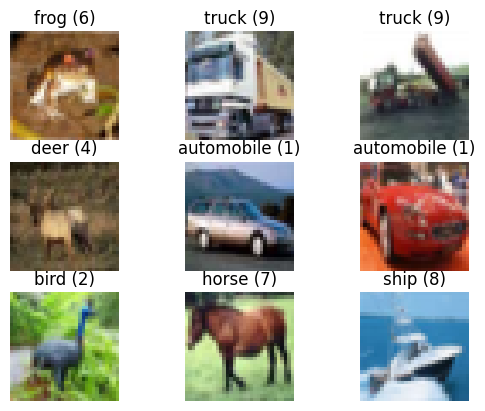

In [6]:
_, ax = plt.subplots(nrows=3, ncols=3)
for i in range(9):
    label_number = np.argmax(y_train[i])
    ax[i // 3, i % 3].imshow(X_train[i])
    ax[i // 3, i % 3].set_title(f'{label_names[label_number]} ({label_number})')
    ax[i // 3, i % 3].axis("off")


### Define the model

Our task will be to classify the images into one of the ten categories. We define a convolutional neural network, which for the purposes of this notebook, is more complicated than it needs to be.

In [7]:
# Construct the model in a function, so that it is quick to create new models
# for each of our experiments.
def make_model():
    m = keras.Sequential([
        keras.layers.Input(shape=(32, 32, 3)),
        keras.layers.Rescaling(1.0 / 255),
        keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        keras.layers.MaxPooling2D((2, 2)),
        keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        keras.layers.MaxPooling2D((2, 2)),
        keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        keras.layers.MaxPooling2D((2, 2)),
        keras.layers.Flatten(),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dense(10, activation='softmax')
    ])

    return m

model = make_model()

For these experiments, we use the simplest optimisation algorithm -- standard stochastic gradient descent (SGD), and give it a try with learning rate of 0.01.

In [8]:
model.compile(
    optimizer=keras.optimizers.SGD(learning_rate=0.01),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

`model.fit` returns a dictionary with results for each training epoch. Keep this so that we can plot it later.

Now start the training:

In [9]:
history = model.fit(
    X_train,
    y_train,
    validation_data=(X_test, y_test),
    batch_size=128,
    epochs=25
)

Epoch 1/25
391/391 ━━━━━━━━━━━━━━━━━━━━ 13s 21ms/step - accuracy: 0.1182 - loss: 2.3004 - val_accuracy: 0.1305 - val_loss: 2.2830
Epoch 2/25
391/391 ━━━━━━━━━━━━━━━━━━━━ 13s 11ms/step - accuracy: 0.1745 - loss: 2.2414 - val_accuracy: 0.2626 - val_loss: 2.0325
Epoch 3/25
391/391 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.2811 - loss: 1.9954 - val_accuracy: 0.3007 - val_loss: 1.9525
Epoch 4/25
391/391 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.3409 - loss: 1.8495 - val_accuracy: 0.2475 - val_loss: 2.0679
Epoch 5/25
391/391 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.3915 - loss: 1.7119 - val_accuracy: 0.3802 - val_loss: 1.7059
Epoch 6/25
391/391 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.4315 - loss: 1.5944 - val_accuracy: 0.4368 - val_loss: 1.5762
Epoch 7/25
391/391 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.4596 - loss: 1.5219 - val_accuracy: 0.4371 - val_loss: 1.5991
Epoch 8/25
391/391 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.4903 - loss: 1.4412 - val_ac

With the training completed, we can visualise the above numbers in a plot to make a better comparison.

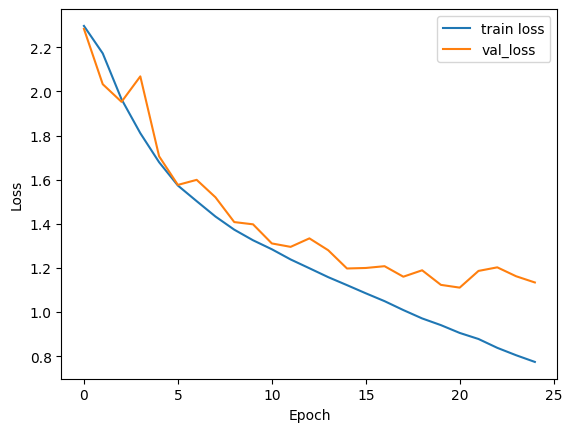

In [10]:
def plot_history(history):
    plt.plot(history.history['loss'], label='train loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

plot_history(history)

### <span style="color: red;">Exercise:<span>

By looking the above plot, reflect on whether the model will perform good or bad on an unseen test set.

The training loss is going down smoothly, but the validation loss seems to converge at ~ 1.3, which indicates that the model is overfitting to the training data.

### First look at callbacks

When the model begins to overfit, validation loss goes up while training loss continues going down. One approach to avoiding overfitting, is to stop training when this happens. To do so, we need to monitor the loss (or other metrics) during training, and interrupt the training loop accordingly. Keras calls such tools _callbacks_. They can be triggered at the end of an epoch, or start of an epoch, or end of a batch, and so on.

The callback we need is called `EarlyStopping`, and it is added into the `.fit` function like so:

In [11]:
# Remember to make a new model, or else we'll continue with the overfitted one!
model = make_model()
model.compile(
    optimizer=keras.optimizers.SGD(learning_rate=0.01),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# EarlyStopping has several optional arguments, check the documentation
early_stopping = keras.callbacks.EarlyStopping(
    patience=5,
    restore_best_weights=True,
    verbose=1,
)

# Run training
history = model.fit(
    X_train,
    y_train,
    validation_data=(X_test, y_test),
    batch_size=64,
    epochs=30,
    callbacks=[early_stopping]  # add a list of callbacks here
)

Epoch 1/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - accuracy: 0.1486 - loss: 2.2466 - val_accuracy: 0.2501 - val_loss: 2.1308
Epoch 2/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 15s 8ms/step - accuracy: 0.3077 - loss: 1.9193 - val_accuracy: 0.3164 - val_loss: 1.8197
Epoch 3/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.3950 - loss: 1.6985 - val_accuracy: 0.3873 - val_loss: 1.6692
Epoch 4/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.4598 - loss: 1.5209 - val_accuracy: 0.4622 - val_loss: 1.5252
Epoch 5/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.4946 - loss: 1.4116 - val_accuracy: 0.4786 - val_loss: 1.4593
Epoch 6/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.5337 - loss: 1.3183 - val_accuracy: 0.5126 - val_loss: 1.4090
Epoch 7/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.5627 - loss: 1.2326 - val_accuracy: 0.4729 - val_loss: 1.5241
Epoch 8/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 0.5852 - loss: 1.1784 - val_accura

Lets plot and see:

In [ ]:
plot_history(history)

For our next experiment, let's try to avoid overfitting by either reducing the complexity of the model, or adding regularisation.

### <span style="color: red;">Exercise:<span>

Remove the last two Conv2D layers of the model, then add a dropout layer (`keras.layers.Dropout`) between the two Dense layers. Train the model and verify that the validation loss flattens.

In [12]:
def make_model():


    # Define your model here

    ## REMOVE
    m = keras.Sequential([
        keras.layers.Input(shape=(32, 32, 3)),
        keras.layers.Rescaling(1.0 / 255),
        keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        keras.layers.MaxPooling2D((2, 2)),
        keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        keras.layers.MaxPooling2D((2, 2)),
        keras.layers.Flatten(),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(10, activation='softmax')
    ])

    return m

model = make_model()

model.compile(
    optimizer=keras.optimizers.SGD(learning_rate=0.01),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    X_train,
    y_train,
    validation_data=(X_test, y_test),
    batch_size=64,
    epochs=25,
)

Epoch 1/25
782/782 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.1655 - loss: 2.2192 - val_accuracy: 0.2783 - val_loss: 1.9693
Epoch 2/25
782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.3245 - loss: 1.8930 - val_accuracy: 0.3578 - val_loss: 1.7715
Epoch 3/25
782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.3901 - loss: 1.7053 - val_accuracy: 0.4446 - val_loss: 1.5766
Epoch 4/25
782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.4442 - loss: 1.5573 - val_accuracy: 0.4988 - val_loss: 1.4068
Epoch 5/25
782/782 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.4728 - loss: 1.4739 - val_accuracy: 0.4810 - val_loss: 1.4288
Epoch 6/25
782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.4991 - loss: 1.3990 - val_accuracy: 0.4566 - val_loss: 1.5486
Epoch 7/25
782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.5164 - loss: 1.3550 - val_accuracy: 0.5331 - val_loss: 1.3111
Epoch 8/25
782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.5365 - loss: 1.2931 - val_accuracy: 

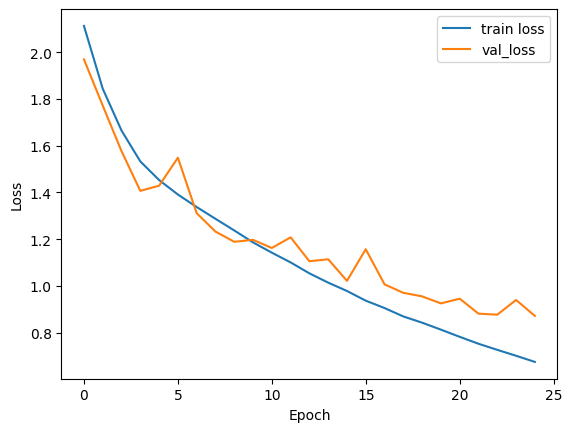

In [14]:
plot_history(history)

In this plot you might see that the validation loss bounces around quite a bit towards the end. As we move closer to the minimum, is would be nice to take smaller steps, to avoid "skipping past" it.
There is a callback for exactly this, namely [`keras.callbacks.ReduceLROnPlateau`](https://keras.io/api/callbacks/reduce_lr_on_plateau/).

Give it a try:

In [15]:
model = make_model()

model.compile(
    optimizer=keras.optimizers.SGD(learning_rate=0.05),     # Can start with a higher learning rate this time
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr=0.0001,
    verbose=1
)

history = model.fit(
    X_train,
    y_train,
    validation_data=(X_test, y_test),
    batch_size=64,
    epochs=25,
    callbacks=[reduce_lr]   # add the callback
)

Epoch 1/25
782/782 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.2255 - loss: 2.1067 - val_accuracy: 0.3701 - val_loss: 1.7040 - learning_rate: 0.0500
Epoch 2/25
782/782 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.4375 - loss: 1.5547 - val_accuracy: 0.4868 - val_loss: 1.4417 - learning_rate: 0.0500
Epoch 3/25
782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.5152 - loss: 1.3427 - val_accuracy: 0.5455 - val_loss: 1.2380 - learning_rate: 0.0500
Epoch 4/25
782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.5700 - loss: 1.1956 - val_accuracy: 0.5482 - val_loss: 1.2535 - learning_rate: 0.0500
Epoch 5/25
782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.6141 - loss: 1.0811 - val_accuracy: 0.5462 - val_loss: 1.2956 - learning_rate: 0.0500
Epoch 6/25
782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.6571 - loss: 0.9747 - val_accuracy: 0.6049 - val_loss: 1.1423 - learning_rate: 0.0500
Epoch 7/25
782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.6871 - loss: 0.8854 - 

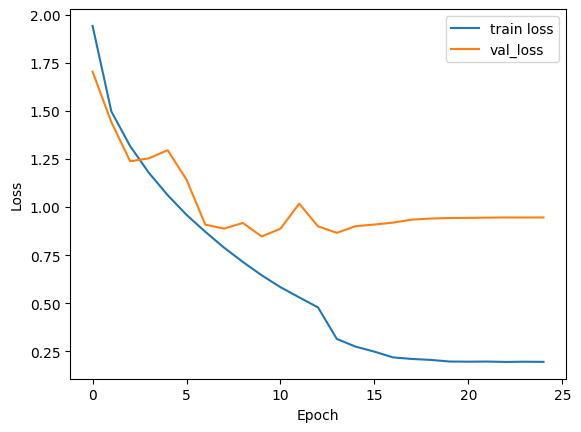

In [16]:
plot_history(history)

## Learning rate schedulers

The above heuristic usually works well, but we can also make more structured approaches. In the [schedulers API](https://keras.io/api/optimizers/learning_rate_schedules/) we find several different strategies for adjusting the learning rate as a function of the training step (batch) number. Since these don't monitor the performance but just look at epoch progression, they are implemented a bit differently, and go as input to the optimiser instead. Let's try an exponential reduction of the learning rate:

In [18]:
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.05,
    decay_steps=100000,
    decay_rate=0.96
)

model = make_model()

model.compile(
    optimizer=keras.optimizers.SGD(learning_rate=lr_schedule),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    X_train,
    y_train,
    validation_data=(X_test, y_test),
    batch_size=64,
    epochs=30,
)

Epoch 1/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.2231 - loss: 2.1142 - val_accuracy: 0.3621 - val_loss: 1.6882
Epoch 2/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.4453 - loss: 1.5403 - val_accuracy: 0.4137 - val_loss: 1.6412
Epoch 3/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.5216 - loss: 1.3339 - val_accuracy: 0.5360 - val_loss: 1.2680
Epoch 4/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.5841 - loss: 1.1710 - val_accuracy: 0.5720 - val_loss: 1.2007
Epoch 5/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.6252 - loss: 1.0462 - val_accuracy: 0.5741 - val_loss: 1.2590
Epoch 6/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.6685 - loss: 0.9472 - val_accuracy: 0.6342 - val_loss: 1.0707
Epoch 7/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.7002 - loss: 0.8463 - val_accuracy: 0.6494 - val_loss: 1.0188
Epoch 8/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.7269 - loss: 0.7680 - val_accuracy: 0.

Before we try out the different schedulers, let's plot how the learning rate is adjusted as training progresses.

First, the exponential decay schedule:

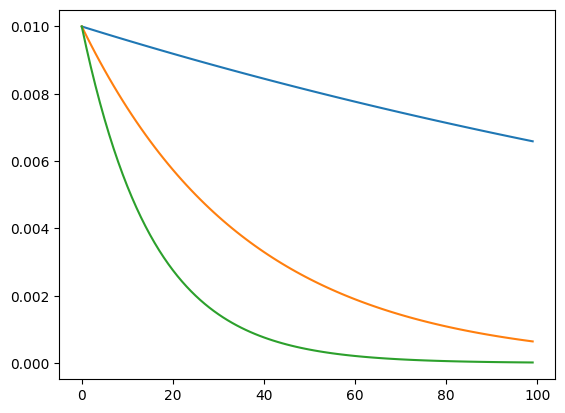

In [19]:
exp_schedule_1 = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=0.01, decay_steps=25, decay_rate=0.90, name="Decay rate 0.90")
exp_schedule_2 = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=0.01, decay_steps=25, decay_rate=0.50, name="Decay rate 0.50")
exp_schedule_3 = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=0.01, decay_steps=25, decay_rate=0.20, name="Decay rate 0.20")

num_steps = 100
plt.plot(range(num_steps), exp_schedule_1(range(num_steps)), label=exp_schedule_1.name)
plt.plot(range(num_steps), exp_schedule_2(range(num_steps)), label=exp_schedule_2.name)
plt.plot(range(num_steps), exp_schedule_3(range(num_steps)), label=exp_schedule_3.name)


### <span style="color: red;">Exercise:<span>

Make similar plots for the cosine decay schedule ([`keras.optimizers.schedules.CosineDecay`](https://keras.io/api/optimizers/learning_rate_schedules/cosine_decay/)).

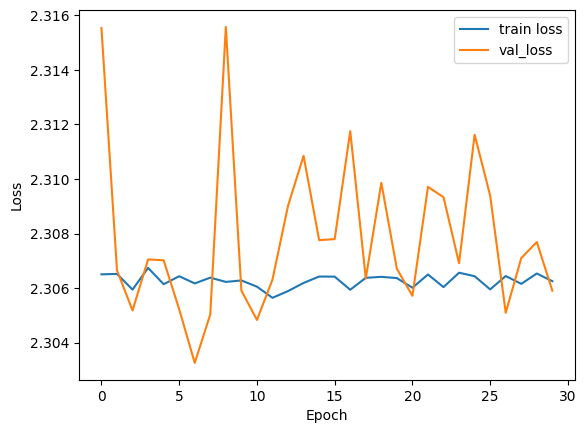

In [35]:
plot_history(history)# plot goes here

### Write you own scheduler!

Maybe training will be even more efficient if the learning rate goes up and down a bit like so:

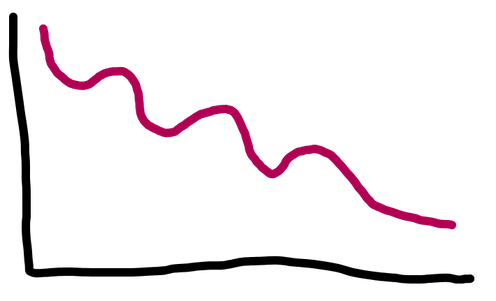





We can make out own scheduling method relatively easily (and be at the forefront of deep learning research) with the learning rate schedules [API](https://keras.io/api/optimizers/learning_rate_schedules/learning_rate_schedule/).

### <span style="color: red;">Exercise:<span>

Implement the `__call__` function below, so that it adjusts the learning rate in a useful way, either like in the drawing above (which is technically called _linear cosine decay_), or something else that you believe would give imploved performance.

Maybe even add some randomness?

In [33]:
class MyLRSchedule(keras.optimizers.schedules.LearningRateSchedule):

    def __init__(self, initial_learning_rate,decay_steps,end_learning_rate,power):
        self.initial_learning_rate = initial_learning_rate
        self.decay_steps = decay_steps
        self.end_learning_rate = end_learning_rate
        self.power = power

    def __call__(self, step):

        learning_rate = self.initial_learning_rate * (1 - step / self.decay_steps)**self.power
        learning_rate = tf.maximum(learning_rate, self.end_learning_rate)
        return learning_rate

Put it to the test:

In [34]:
# Add the scheduler (you can choose the initial learning rate yourself)
optimizer = keras.optimizers.SGD(learning_rate=MyLRSchedule(0.1, 10000,0.96, 1.0))

model = make_model()

model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    X_train,
    y_train,
    validation_data=(X_test, y_test),
    batch_size=64,
    epochs=30,
)

Epoch 1/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 22s 26ms/step - accuracy: 0.1005 - loss: 2.3069 - val_accuracy: 0.1000 - val_loss: 2.3155
Epoch 2/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 24s 6ms/step - accuracy: 0.0943 - loss: 2.3070 - val_accuracy: 0.1000 - val_loss: 2.3067
Epoch 3/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.1004 - loss: 2.3057 - val_accuracy: 0.1000 - val_loss: 2.3052
Epoch 4/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.0984 - loss: 2.3066 - val_accuracy: 0.1000 - val_loss: 2.3071
Epoch 5/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.1019 - loss: 2.3061 - val_accuracy: 0.1000 - val_loss: 2.3070
Epoch 6/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.0970 - loss: 2.3066 - val_accuracy: 0.1000 - val_loss: 2.3052
Epoch 7/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.0973 - loss: 2.3060 - val_accuracy: 0.1000 - val_loss: 2.3033
Epoch 8/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.0995 - loss: 2.3062 - val_accuracy:

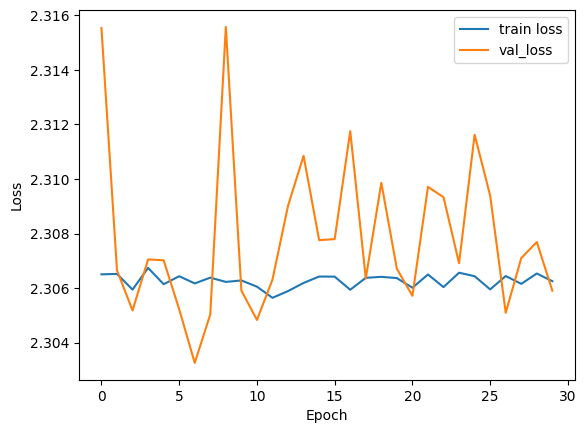

In [36]:
plot_history(history)